# Gravity-darkened intensity using the Von Zeipel Law:

We need to find a function $F(x,y)$ which gives us the flux of the star at different x and y positions on the projected surface of the star.

We can use the Von Zeipel Law: $$T = T_{pole} \frac{g^{\beta}}{g_{pole}^{\beta}}$$

Where $T_{pole}$ is the temperature at the pole, $\beta$ is a scaling parameter, and $T$ and $g$ are the temperature and stellar surface gravity at a given point on the stellar surface. We can plug this into any blackbody equation to obtain flux. 

In [1]:
import sympy as sp
from sympy import symbols, sin, cos, Matrix, Eq, Rational, floor, sqrt, S
from sympy import simplify, factorial, pi, binomial, factor, expand, collect
from sympy.functions.special.tensor_functions import KroneckerDelta
from sympy import init_printing
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *
import pandas as pd
from sympy import latex
from scipy.optimize import curve_fit
from IPython.display import display, Math

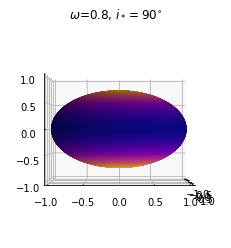

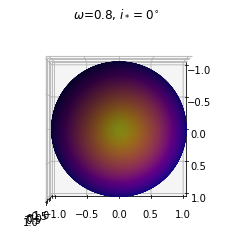

In [4]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import utils  #code I wrote to plot a spheroid, adapted from Gdit (Aaron Dotter)
utils.plot_one_spheroid_inc(omega=0.8,inc=0)
utils.plot_one_spheroid_inc(omega=0.8,inc=90)

***

## Von Zeipel Law:

$$T = T_{pole} \frac{g^{\beta}}{g_{pole}^{\beta}}$$

Let's use Von Zeipel's Law as a function of x, y, z on the stellar surface. [Barnes et al. 2009](https://arxiv.org/pdf/0909.1752.pdf) has the math for this. 
Let's call x0, y0, and z0 the x, y and z components on the stellar surface *with no obliquity* relative to us. ie, this is the simple case where the star's rotation axis is parallel to the y axis. 



### Surface gravity:

In [5]:
x0, y0, z0= sp.symbols("x0 y0 z0",real=True,positive=True) #can switch positive=True off, but sympy simplifies better
Omega, R, R_perp, G, M, beta, T_pole, g_pole = sp.symbols(
    "Omega R R_perp G M beta T_pole g_pole"
    ,real=True,positive=True)
R = sqrt(x0**2+y0**2+z0**2)
R_perp = sqrt(x0**2+z0**2)
R_vec = Matrix([x0/R,y0/R,z0/R])
R_perpvec = Matrix([x0/R_perp,0,  z0/R_perp])
g_vec = -(G*M/R**2)*R_vec + Omega**2*R_perp*R_perpvec
display(Math(r'\vec{g} = '+latex(g_vec)))

<IPython.core.display.Math object>

Also, $\Omega$, the angular rotational velocity, can be written as a dimensionless variable $\omega$ based on the prescription ([from Lara & Rieutord 2011](https://arxiv.org/abs/1109.3038)): $$ \omega = \Omega \sqrt{\frac{R_{eq}^3}{GM}}$$

In [6]:
R_eq, omega, b = sp.symbols("R_eq, omega, b",positive=True,real=True)
g_vec = g_vec.subs([(Omega,omega*sqrt(G*M/R_eq**3))])
display(Math(r'\vec{g} = ' + latex(g_vec)))

<IPython.core.display.Math object>

### Plugging into Von Zeipel Law:

Writing this into Von Zeipel's Law, we can obtain a function for the temperature of the star, where b is the semi-minor axis of the stellar ellipsoid, or the oblateness coefficient:

In [7]:
g_pole = g_vec.subs([(x0,0),(y0,R_eq*b),(z0,0)])
T = T_pole * (g_vec.norm()/g_pole.norm())**beta
display(Math('T = ' + latex(T)))

<IPython.core.display.Math object>

We plugged in the values (0, $b R_{eq}$, 0) into the surface gravity vector above to find the surface gravity at the poles of the star, which we plug into the denominator of the equation. This results in a lot of nice cancellations, getting rid of G and M:

In [8]:
g_pole = g_vec.subs([(x0,0),(y0,R_eq*b),(z0,0)])
T = T_pole * simplify((g_vec.norm()/g_pole.norm())**beta)
display(Math('T = ' + latex(T)))

<IPython.core.display.Math object>

Assuming a spherical star, the equation for the star's photosphere would be: 
$$ x_0^2 + y_0^2 +z_0^2 = R_{eq}^2$$

From [Barnes et al. 2009](https://arxiv.org/pdf/0909.1752.pdf):

However, the star is actually oblate, so let's add the oblateness coefficient b in:

$$ x_0^2 + \left(\frac{y_0}{b}\right)^2 +z_0^2 = R_{eq}^2$$

In [9]:
T_simp = (T_pole * (simplify(g_vec.norm().subs([(z0,sqrt(R_eq**2 - x0**2 - (y0/b)**2))]))/g_pole.norm())**beta)
display(Math('T = ' + latex(T_simp)))

<IPython.core.display.Math object>

### Rotating the star 
In addition, the star could be angled by a stellar inclination of $\varphi$.

The rotation matrix for this is:

In [10]:
varphi = sp.symbols('varphi', real=True, positive=True)
rot = Matrix([[1,0,0],[0,cos(varphi),sin(varphi)],[0,-sin(varphi),cos(varphi)]])
display(Math(r'\vec{x_0} = ' + latex(rot)+r'\vec{x}'))

<IPython.core.display.Math object>

When we plug in the "true" coordinates x, y, and z into this rotation matrix we get:

In [11]:
x, y, z = sp.symbols('x, y, z', real=True,positive=True) #can switch positive=True off, but sympy simplifies better
x_vec = Matrix([x,y,z])
x0_vec = Matrix([rot.row(0).dot(x_vec),rot.row(1).dot(x_vec),rot.row(2).dot(x_vec)])
display(Math(r'\begin{bmatrix}x_0\\y_0\\z_0\end{bmatrix} = ' + latex(x0_vec)))

<IPython.core.display.Math object>

In the simple spherical case the surface of the star can be modeled as a function of x and y alone:  $$z(x, y) = \sqrt{R_{eq}^2 - x^2 -y^2}$$.

Due to the oblateness, however, things are more complicated, and z(x, y) must also include $\varphi$ and $f$. This can be found (in the same way as [Barnes et al. 2009](https://arxiv.org/pdf/0909.1752.pdf)), by solving the quadratic equation to find z:

In [12]:
x, y, z= sp.symbols("x y z",real=True,positive=True) #can switch positive=True off, but sympy simplifies better

z_soln = sp.solvers.solve(x**2 + ((y*cos(varphi) + z*sin(varphi))/b)**2 + (-y*sin(varphi) + z*cos(varphi))**2 - R_eq**2, z)[0]
z_soln = sp.simplify(z_soln)
display(Math(r'z = ' + latex(z_soln)))

<IPython.core.display.Math object>

### Rotating to pole on configuration:

Remember, this is how the star looks like in pole on configuration. The projected stellar surface in pole on configuration is simply a circle with the hottest part in the center. We can rotate the star to pole on configuration ($\varphi = \pi/2$) to simplify the math:

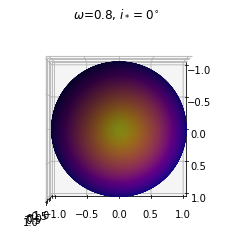

In [13]:
utils.plot_one_spheroid_inc(omega=0.8,inc=90)

Let's make the simplification of $\varphi = \pi/2$. Also, let's substitute $x$ and $y$ for $x_0, y_0, z_0$. 

We can also substitute $R_{eq}$ for $1$ to work on the unit sphere in dimensionless coordinates. The only variables we are interested in to create the temperature map should be $\omega$, $\beta$, $T_{pole}$, $x, y$ and $z$.

In [14]:
T_rot = T_simp.subs([(x0,x),(y0,(y*cos(varphi) + (z_soln)*sin(varphi))),(z0,(-y*sin(varphi) + (z_soln)*cos(varphi)))])
T_rot = T_rot.subs([(R_eq,1), (varphi, pi/2)])
display(Math(r'T(x,y) = ' + latex(T_rot)))

<IPython.core.display.Math object>

Looking at the star in pole on configuration, the equation seems more complicated. But we have now gotten rid of z, making the temperature simply a function of $x$ and $y$. 

Furthermore, so we see a lot of $1-x^2 -y^2$ because the projected stellar surface is a circle. We can create a parameter $\alpha$ to encapsulate this more succinctly:

In [15]:
alpha = sp.symbols("alpha",real=True)
T_rot_simp = simplify(T_rot.subs([(1-x**2-y**2, alpha)]));
display(Math(r'T = ' + latex(T_rot_simp)))

<IPython.core.display.Math object>

Collecting terms, we can simplify:

In [16]:
T_rot_simp = collect(T_rot_simp, (-omega**2*sqrt(alpha*b**2 - alpha + 1)**3 + 1)**2)
display(Math(r'T = ' + latex(T_rot_simp)))

<IPython.core.display.Math object>

In [17]:
latex(T_rot_simp)

'T_{pole} \\left(b^{2} \\sqrt{\\frac{- \\alpha b^{2} + \\left(\\alpha - 1\\right) \\left(- \\omega^{2} \\left(\\alpha b^{2} - \\alpha + 1\\right)^{\\frac{3}{2}} + 1\\right)^{2}}{\\left(- \\alpha b^{2} + \\alpha - 1\\right)^{3}}}\\right)^{\\beta}'

### Testing for some real-life parameters:

Let's take a star with some realistic parameters; $\omega = 0.23$, $\beta = 0.22$, $b = 0.98$ and $T_{pole} = 7600K$

The equatorial temperature can be calculated by plugging in $1-x^2-y^2 = \alpha=0$

In [18]:
T_eq = T_rot_simp.evalf(subs={alpha: 0, b:0.98,beta:0.22, omega:0.23, T_pole:7600})
display(Math(latex(T_eq) + r'K'))

<IPython.core.display.Math object>

***

## Oblateness as a function of angluar velocity:

Up till now, we have used b, the semi-minor axis of the stellar ellipsoid to parametrize the oblateness. However, we would like to know if we can find the oblateness of the star as a function of its rotation rate $\omega$, which would remove the need for using a separate oblateness factor. 


According to [Bouvier et al. 2013](https://arxiv.org/pdf/1307.2891.pdf), the radius of a star can be written as a function of $\omega$ using the following relation (according to the Roche model for stellar equipotential surfaces):

$$R_{eq} = \frac{3 R_{polar} \cos{\left(\frac{\operatorname{arccos}{\left(\omega \right)}}{3} + \frac{\pi}{3} \right)}}{\omega}$$

However, their $\omega$ is defined a little differently from ours (theirs is the rotation as a fraction of breakup velocity whereas ours follows [Lara & Rieutord 2011](https://arxiv.org/abs/1109.3038), the angular velocity as a fraction of the Keplerian angular velocity at the equator. We correct this by multiplying $\omega$ by $(2/3)^{-3/2}$

b is defined as $\frac{R_{polar}}{R_{eq}}$, so we can write b as a function of omega as follows:

In [19]:
omega = sp.symbols(
    "omega"
    ,real=True,positive=True)

omega_ours = S("(2/3)**(-3/2)") * omega
b_omega = ((omega_ours)/3) / sin((sp.asin(omega_ours))/3)
display(Math(r'b = ' + latex(b_omega)))

<IPython.core.display.Math object>

In [20]:
rho = sp.symbols("rho" ,real=True,positive=True)
f_pyt = 3.*Omega*Omega/(8.*G*pi*rho)
f_pyt

0.375*Omega**2/(pi*G*rho)

In [21]:
f_pyt_req = f_pyt.subs([(rho,M/(4*pi/3*R_eq**2*R_eq*b))])
f_pyt_req

0.5*Omega**2*R_eq**3*b/(G*M)

In [22]:
f_pyt_req.subs([(Omega, omega*sqrt(G*M/R_eq**3))])

0.5*b*omega**2

In [23]:
f_zahle = (-3/2)*G*M/R_eq

Elsewhere in this code, we have used $f$ as the oblateness factor; this is simply $1-b$.